In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./Project_3.csv
./clustered_data.csv
./Project_3.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.ipynb
./.ipynb_checkpoints/Project_3-checkpoint.csv
./.ipynb_checkpoints/clustered_data-checkpoint.csv
./data/hello
./data/.ipynb_checkpoints/hello-checkpoint


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Assignment: As a customer I would like to be able to assist my sales team to target the correct customer market. Given the data emailed to you provide Insight into what you see. Then Create a ML model that would allow for a Prediction of Whether a Cog would be Purchased by the given customer.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

The data was provided to us via csv file.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("Project_3.csv")

# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

In [4]:
df_dropped = df.drop(columns=["name"])

In [5]:
# if the item is less than 0, append the abs value to new column and set old "Purchased" value to 0

df_dummies = pd.get_dummies(df_dropped["Purchased"], dtype=int)
df_one_hot = pd.concat([df_dropped, df_dummies], axis=1)
df_one_hot = df_one_hot.rename(columns={-1: "Returned", 0: "Not Bought", 1: "Bought"})
df_one_hot["Bought"] += np.where(df_one_hot["Returned"] == 1, 1, 0)
df_one_hot.head()

,User ID,Gender,Age,EstimatedSalary,Purchased,Returned,Not Bought,Bought
0,10000,Male,23,122492,1,0,0,1
1,10001,Female,47,142543,0,0,1,0
2,10002,Female,54,70131,1,0,0,1
3,10003,Male,20,108437,0,0,1,0
4,10004,Male,57,100832,1,0,0,1


In [6]:
import matplotlib.pyplot as plt

In [7]:
df_no_dupes = df_one_hot.drop_duplicates()
print(len(df_one_hot), len(df_no_dupes))

1001 1001


In [8]:
df_no_dupes = df_no_dupes.drop(columns="Purchased")

<BarContainer object of 1001 artists>

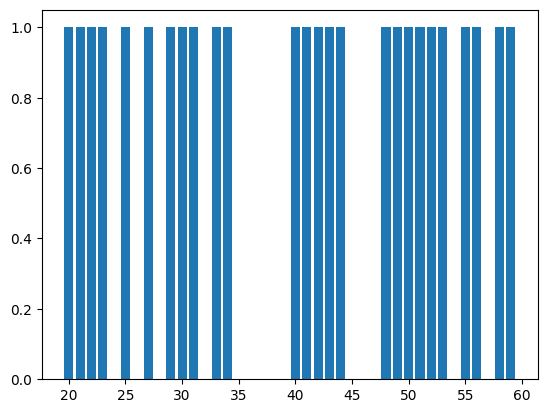

In [9]:
df_sort_age = df_no_dupes.sort_values(by="Age")
plt.bar(df_sort_age["Age"], df_sort_age["Returned"])

Older people did NOT return products more as they got 

In [10]:
import numpy as np

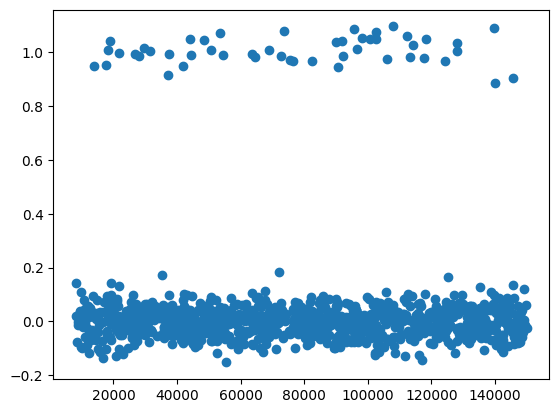

In [11]:
jitter = np.random.normal(0, 0.05, len(df_no_dupes))
price_jit = df_sort_age["Returned"] + jitter
plt.scatter(df_sort_age["EstimatedSalary"], price_jit)

In [12]:
df_gender_dummies = pd.get_dummies(df_no_dupes["Gender"], dtype=int)
df_one_hot = pd.concat([df_no_dupes, df_gender_dummies], axis=1)
df_one_hot = df_one_hot.drop(columns=["Gender", "Female"])
df_one_hot = df_one_hot.rename(columns={"Male": "Is_male"})

In [13]:
df_one_hot.head()

,User ID,Age,EstimatedSalary,Returned,Not Bought,Bought,Is_male
0,10000,23,122492,0,0,1,1
1,10001,47,142543,0,1,0,0
2,10002,54,70131,0,0,1,0
3,10003,20,108437,0,1,0,1
4,10004,57,100832,0,0,1,1


In [14]:
correlation_matrix = df_one_hot.corr()
correlation_matrix = correlation_matrix["Bought"].sort_values(ascending=False)
print(correlation_matrix)

Bought             1.000000
Returned           0.228463
User ID            0.061187
EstimatedSalary    0.005784
Is_male           -0.025220
Age               -0.091423
Not Bought        -1.000000
Name: Bought, dtype: float64


In [15]:
from sklearn.cluster import KMeans

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [17]:
df_scaled = scaler.fit_transform(df_one_hot)

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(df_scaled)
print(labels)

[1 0 1 ... 1 1 1]


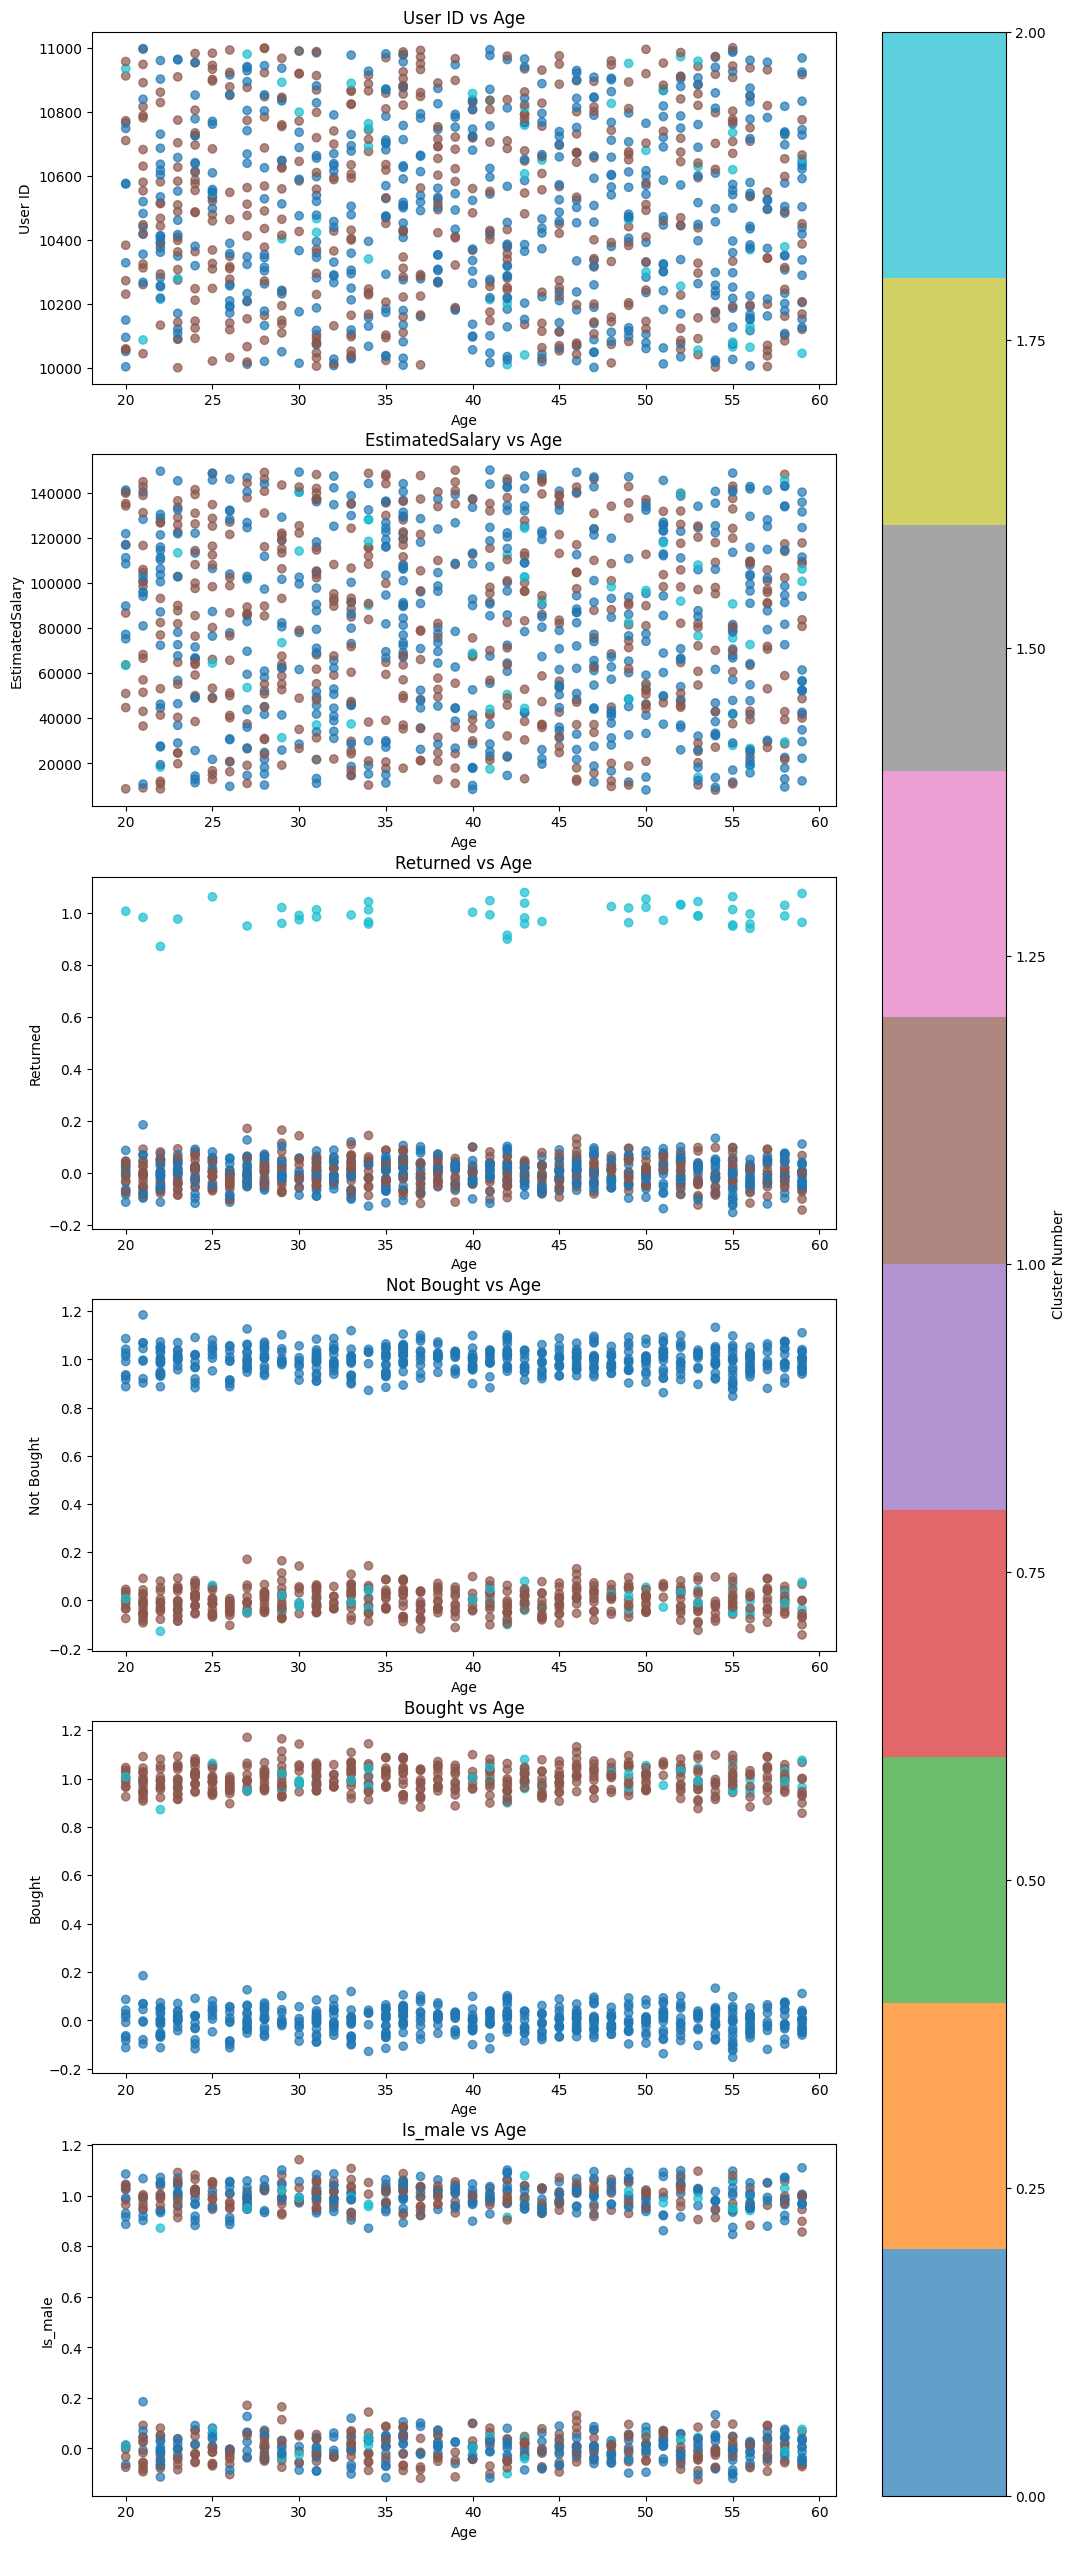

In [19]:
df_one_hot["Cluster"] = labels

x_feature = "Age"
features = [col for col in df_one_hot.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_one_hot[x_feature],
        df_one_hot[feature] + jitter,
        c=df_one_hot["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

fig.colorbar(scatter, ax=axes, label="Cluster Number")
plt.show()

Everyone who returned stuff is in cluster 2.

In [20]:
cluster_means = df_one_hot.groupby("Cluster").mean(numeric_only=True)
print(cluster_means)

              User ID        Age  EstimatedSalary  Returned  Not Bought  \
Cluster                                                                   
0        10482.442460  40.555556     79290.162698       0.0         1.0   
1        10515.839286  37.991071     80115.908482       0.0         0.0   
2        10535.775510  42.673469     76575.632653       1.0         0.0   

         Bought   Is_male  
Cluster                    
0           0.0  0.496032  
1           1.0  0.464286  
2           1.0  0.530612  


I think the most unique attribute is the returned one. There aren't a lot of people who did return the cog, but I can't really see a trend right now. 

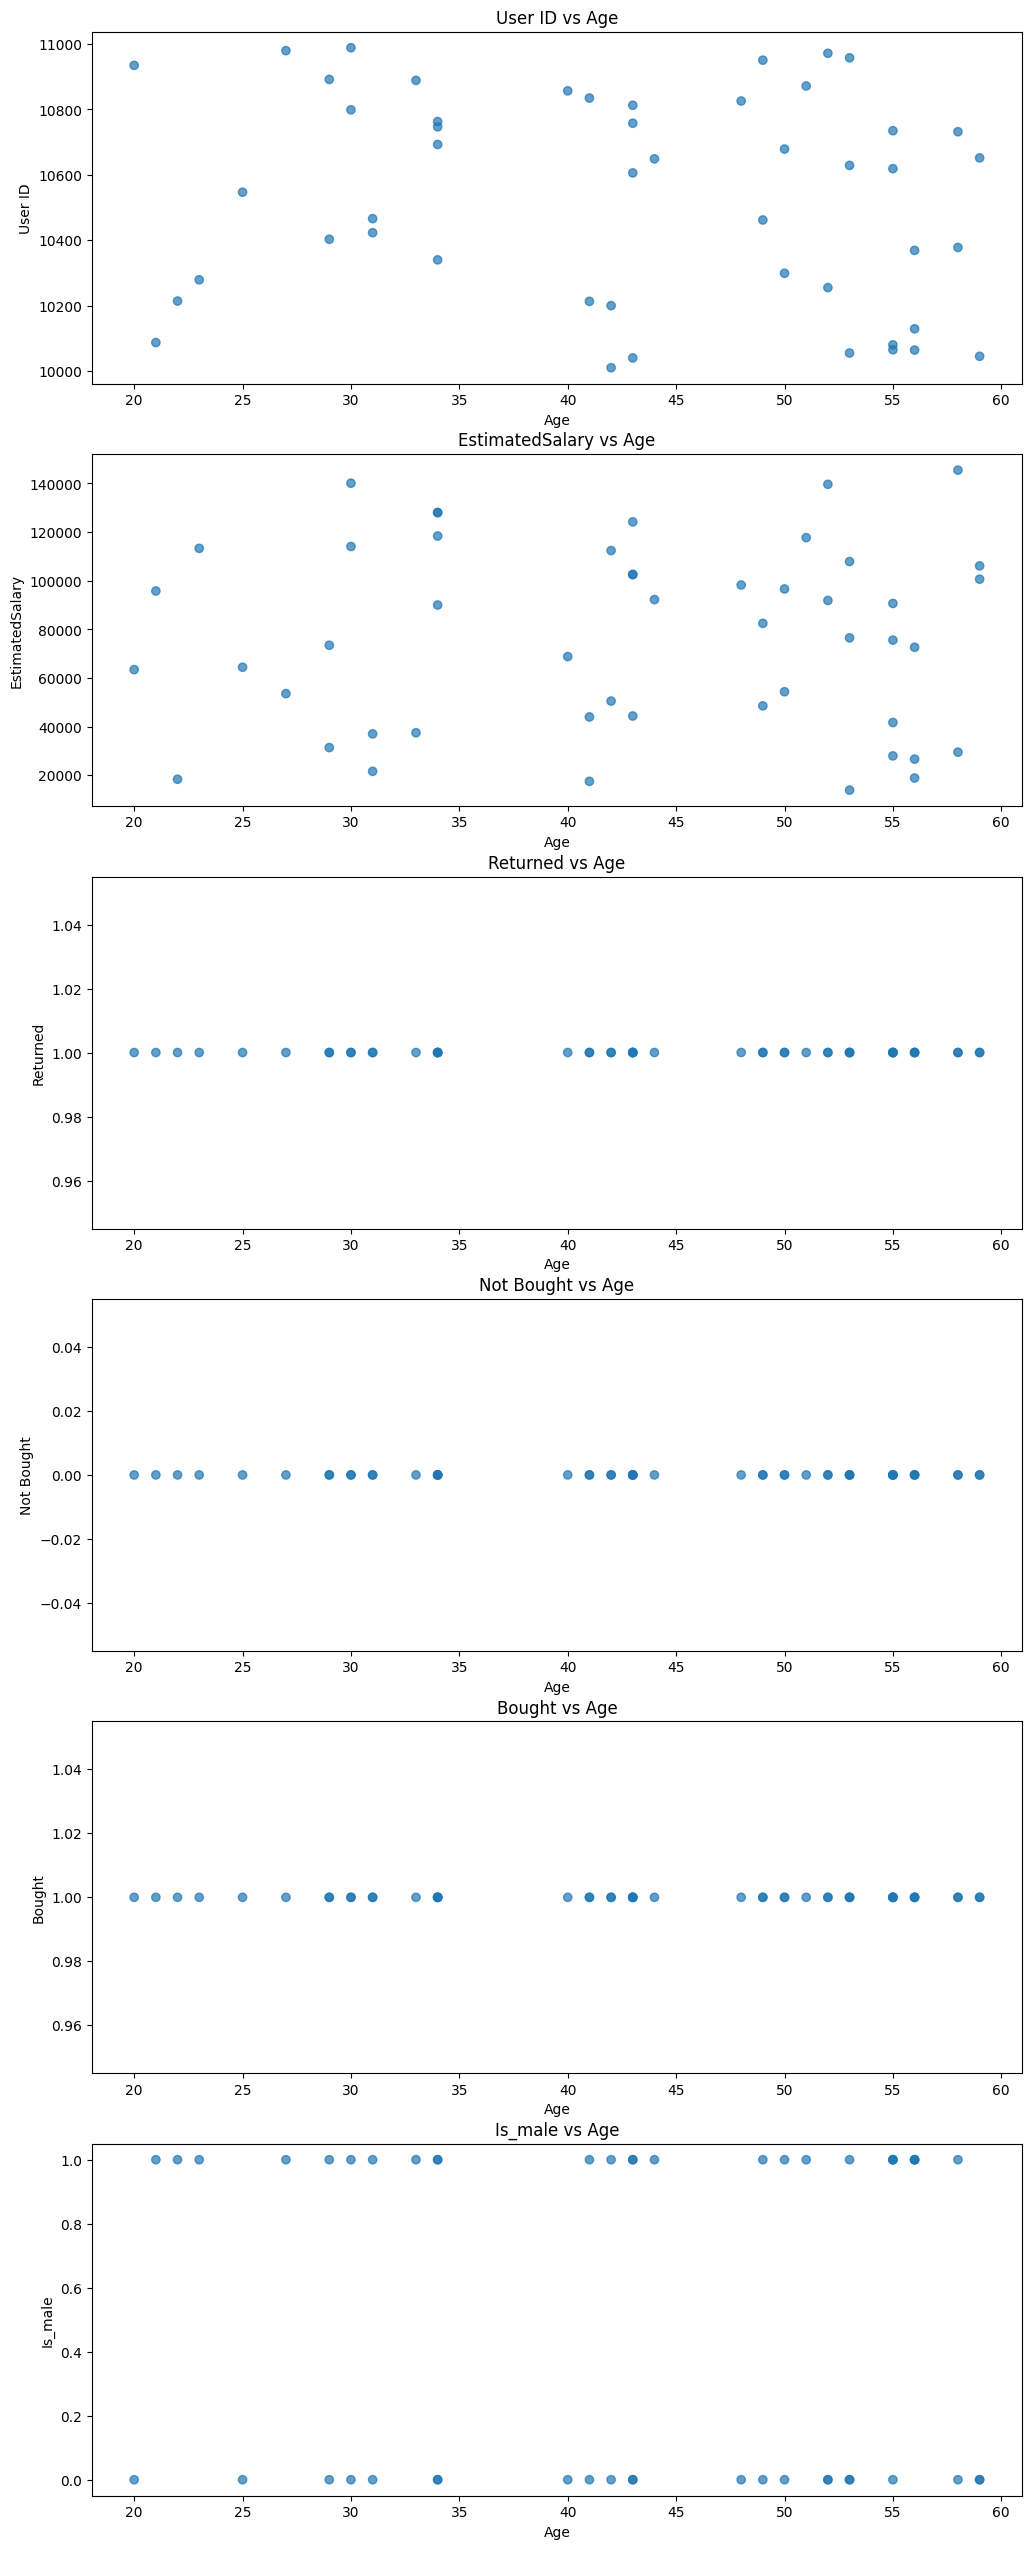

In [21]:
df_returned = df_one_hot[df_one_hot["Cluster"] == 2]

x_feature = "Age"
features = [col for col in df_returned.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]
    
jitter_returned = np.random.normal(0, 0.01, len(df_returned))
for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_returned[x_feature],
        df_returned[feature],
        c=df_returned["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

Unfortunately I still don't know what's going on. The only thing I have been to find it the fact that both men and women returned this product around a big age, like multiples of 5 (25, 30, 35, etc.) This seems unimportant, however.

Now I'm going to cluster by user id (chronological) to see if that will reveal some trends.

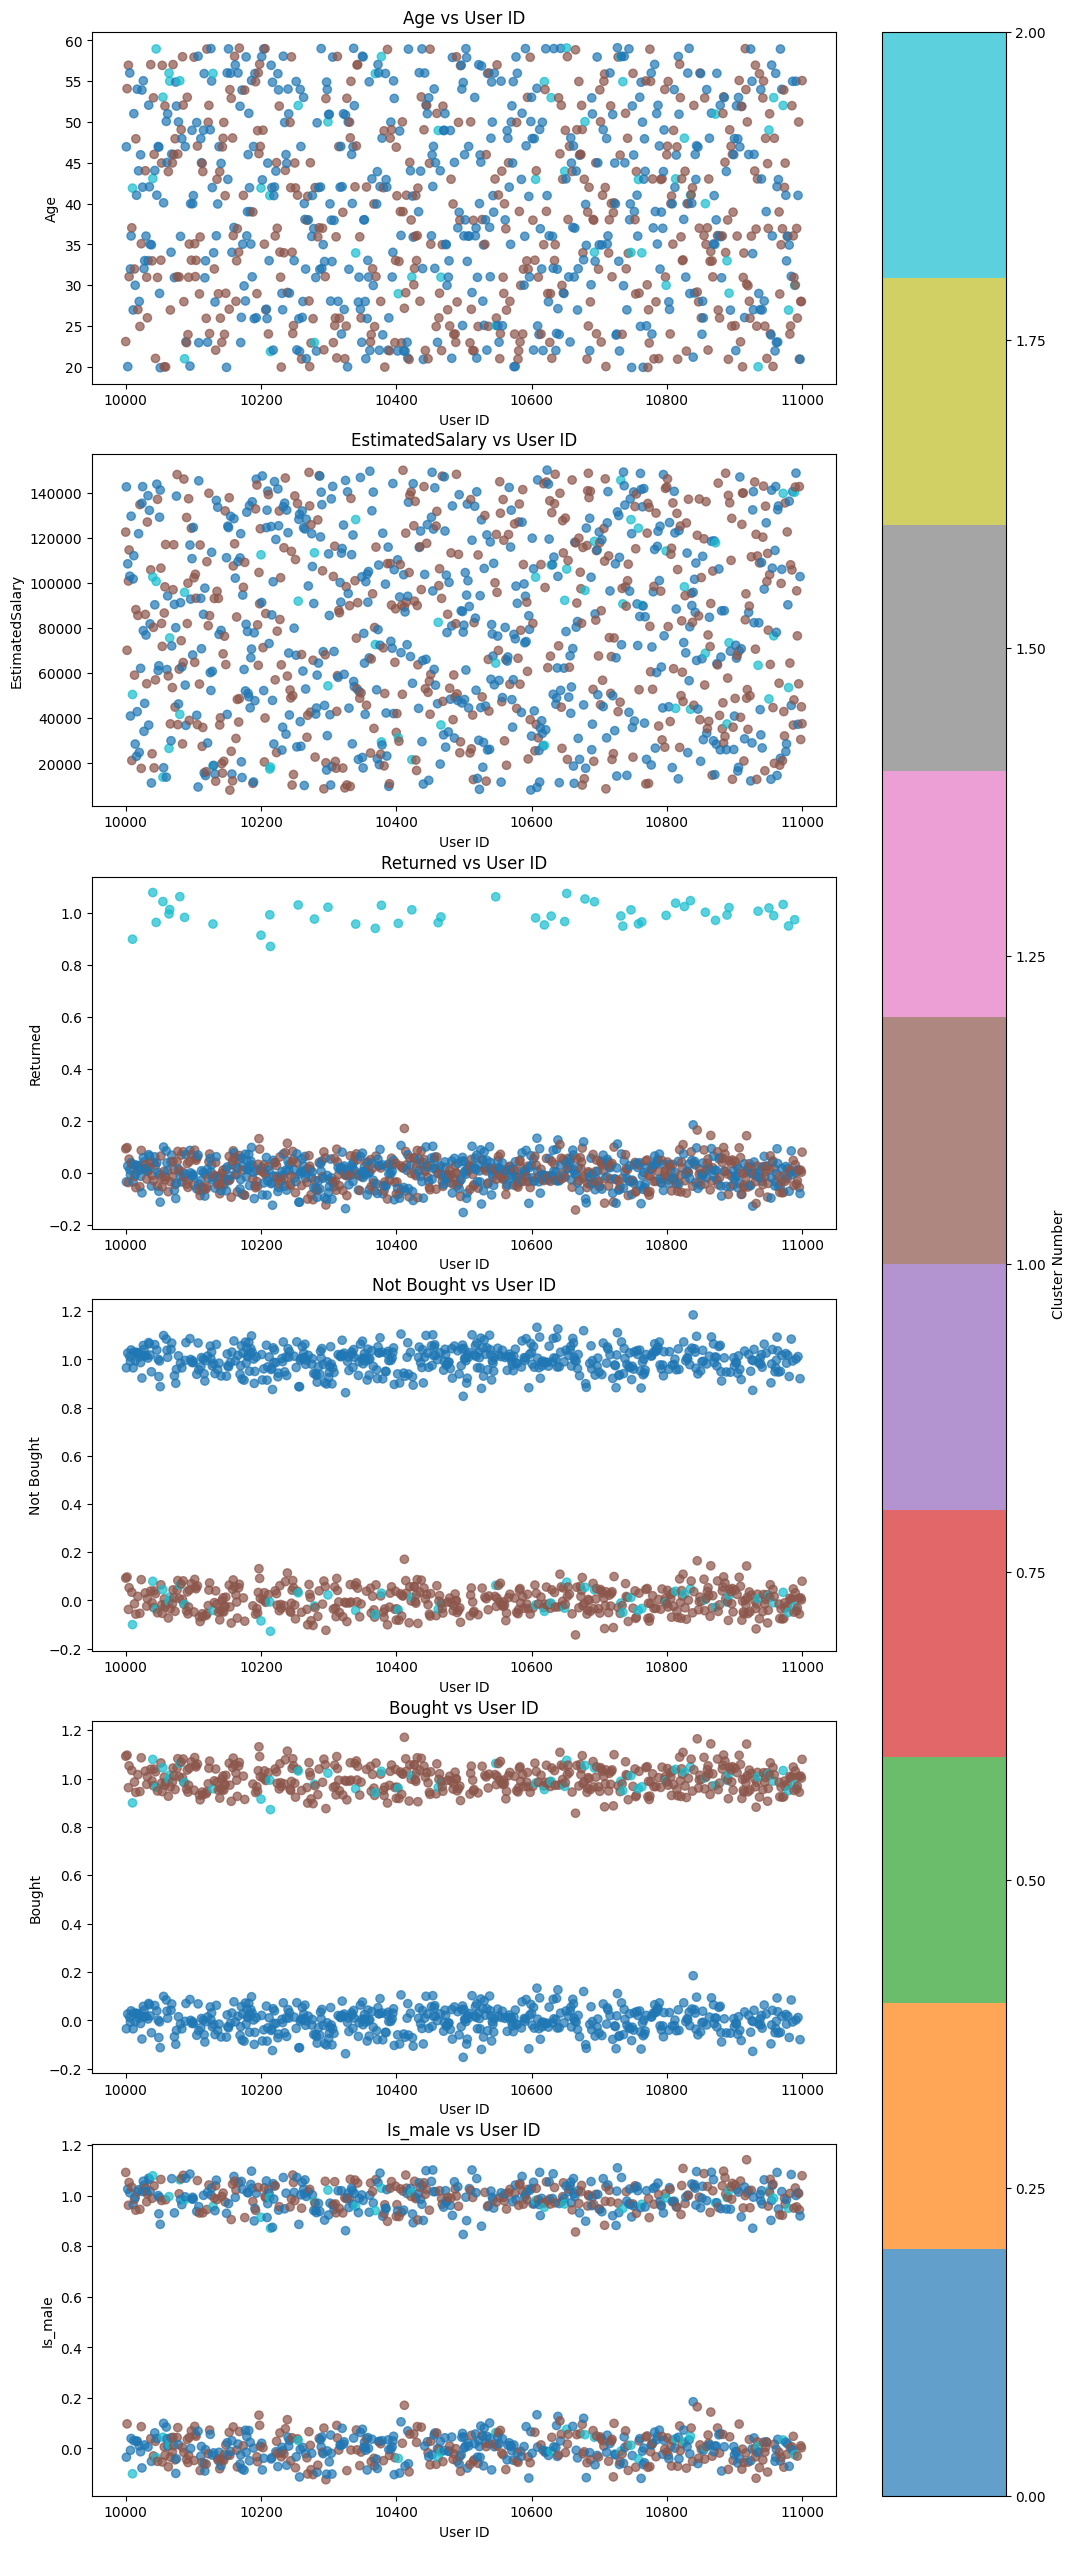

In [22]:
df_one_hot["Cluster"] = labels

x_feature = "User ID"
features = [col for col in df_one_hot.columns if col not in [x_feature, "Cluster"]]

fig, axes = plt.subplots(len(features), 1, figsize=(12, 32))

if len(features) == 1:
    axes = [axes]

for ax, feature in zip(axes, features):
    scatter = ax.scatter(
        df_one_hot[x_feature],
        df_one_hot[feature] + jitter,
        c=df_one_hot["Cluster"],
        cmap="tab10",
        alpha=0.7
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(feature)
    ax.set_title(f"{feature} vs {x_feature}")

fig.colorbar(scatter, ax=axes, label="Cluster Number")
plt.show()

I'm still not sure if there is a trend here. All of the data here is mostly uniform.

# 4.Prepare the Data


Apply any data transformations and explain what and why


In [23]:
df_one_hot.to_csv("clustered_data.csv")

In [24]:
df_clustered = pd.read_csv("clustered_data.csv")
df_clustered.drop(df_clustered.columns[df_clustered.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
df_clustered.drop(columns={"Cluster"})

,User ID,Age,EstimatedSalary,Returned,Not Bought,Bought,Is_male
0,10000,23,122492,0,0,1,1
1,10001,47,142543,0,1,0,0
2,10002,54,70131,0,0,1,0
3,10003,20,108437,0,1,0,1
4,10004,57,100832,0,0,1,1
...,...,...,...,...,...,...,...
996,10996,21,142656,0,0,1,1
997,10997,21,102775,0,1,0,1
998,10998,28,30593,0,0,1,0
999,10999,28,45083,0,0,1,0


I did a lot of data manipulation while clustering already. 

One hot encoding: I one hot encoded the gender as well as the returned not bought and bought columns. 
Scaling: I also scaled the salaries since they were skewing the data due to their large sizes. However, depending on whichever model I choose, I may not need to scale these values.

# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [25]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
from sklearn.model_selection import train_test_split

In [33]:
np.random.seed(42)
torch.manual_seed(42)

X = df_one_hot.drop(columns=["Bought", "Not Bought", "Returned"]).values
y = df_one_hot["Bought"].values

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=False)

trainX = torch.tensor(X_train[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y_train[:, None], dtype=torch.float32)
testX = torch.tensor(X_test[:, :, None], dtype=torch.float32)
testY = torch.tensor(y_test[:, None], dtype=torch.float32)

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        print(h0.size())
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [30]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [31]:
num_epochs = 100
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0 = h0.detach()
    c0 = c0.detach()

    with torch.no_grad():
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE Loss: {np.sqrt(loss.item()):.4f}')

torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
Epoch [10/100], Loss: 0.2168, RMSE Loss: 0.4656
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
Epoch [20/100], Loss: 0.1122, RMSE Loss: 0.3350
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
Epoch [30/100], Loss: 0.0242, RMSE Loss: 0.1555
torch.Size([1, 800, 100])
torch.Size([1, 800, 100])
torch.Size([1, 800, 100]

In [32]:
model.eval()
predicted, _, _ = model(testX, h0, c0)

original = df_one_hot["Bought"]
time_steps = df_one_hot["User ID"]

# predicted[::30] += 0.2 
# predicted[::70] -= 0.2

plt.figure(figsize=(12, 6))
plt.scatter(time_steps, original, label='Original Data')
plt.scatter(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('User ID')
plt.ylabel('Value')
plt.legend()
plt.show()

torch.Size([1, 800, 100])


RuntimeError: Expected hidden[0] size (1, 201, 100), got [1, 800, 100]

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 


In [ ]:
def infrence(prams):
    results = m.run(prams)
    return results 